## For running radiative transfer on saved cross section matrices. 


In [136]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage.filters import gaussian_filter1d
from hapi import *
import pandas as pd

from matplotlib.font_manager import FontProperties
from scipy.interpolate import CubicSpline, BSpline

%run simulate_radiances_utils.py
%run locations.py


font = {'weight' : 'bold',
        'size'   : 12}
label_fontdict = {'weight' : 'bold',
        'size'   : 12}
title_fontdict = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# unit conversions 
W_m_mW_cm = 1e2*1e3

In [127]:
# path to profile timeseries over summit
profile_ts_file_path = "/net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_all.nc"

# path to julia-generation cross sections
input_cs_matrix_rel_path = '/net/fluo/data2/groupMembers/cchristo/cs_matrices/summit/julia_generated/'


# path formatting 
input_cs_matrix_path_format = input_cs_matrix_rel_path + '{year}/cs_matrix_{year}{month:02d}{day:02d}_{hour:02d}{minute:02d}.nc'


## Open summit profilesm

In [128]:
all_profiles = xr.open_dataset(profile_ts_file_path)

In [129]:
all_profiles

<xarray.Dataset>
Dimensions:  (lev: 72, time: 15832)
Coordinates:
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
    lat      float64 ...
    lon      float64 ...
  * time     (time) datetime64[ns] 2011-01-01T01:30:00 ... 2016-06-01T22:30:00
Data variables:
    PS       (time) float32 ...
    PL       (time, lev) float32 ...
    QV       (time, lev) float32 ...
    T        (time, lev) float32 ...
    DELP     (time, lev) float32 ...
Attributes:
    History:                           Original file generated: Thu Jun 12 20...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg3_3d...
    Filename:                          MERRA2_400.tavg3_3d_asm_Nv.20110101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T3NVASM
    GranuleID:                         MERRA2_400.tavg3_3d_asm_Nv.20110101.nc4
    ProductionDateTime:                Original file generated: Thu Jun 12 20...
    LongName:                          MERRA2 tavg3_3d_asm_Nv: 3d,3-Hourly,Ti...
    Title:                             MERRA2 tavg3_3d_asm_Nv: 3d,3-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625 (72 native layers)
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/SUOQESM06LPK
    RangeBeginningDate:                2011-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2011-01-01
    RangeEndingTime:                   23:59:59.000000

### Feldman et al. looked at 2011 - 2015 over summit

In [130]:
all_times = pd.date_range(start = '2011-01-01 1:30:00',
                          end = '2016-01-01 1:30:00',
                          freq = '3H')

In [131]:
# all_times[:5]
time_i = all_times[10]

In [132]:
time_i

Timestamp('2011-01-02 07:30:00', freq='3H')

In [133]:
# profile properties
prof_i_ds = all_profiles.sel(time = time_i)
p_prof, T_prof, dz_prof,  vmr_h2o_prof, VCD_dry_prof, rho_N_h2o_prof, rho_N_prof = compute_profile_properties_merra2(prof_i_ds, 
                                                                                                                     verbose=False)

# open cs_matrix 
input_cs_matrix_path = input_cs_matrix_path_format.format(year = time_i.year, 
                                                             month = time_i.month, 
                                                             day = time_i.day,
                                                             hour = time_i.hour, 
                                                             minute = time_i.minute)
cs_matrix_ds = xr.open_dataset(input_cs_matrix_path)
cs_matrix_co2 = cs_matrix_ds['cs_matrix_co2'].values
cs_matrix_ch4 = cs_matrix_ds['cs_matrix_ch4'].values
cs_matrix_h2o = cs_matrix_ds['cs_matrix_h2o'].values

# nu = cs_matrix_ds['nu'].values
nu_ = np.linspace(400,2099.99, 170000)
NLEV = len(cs_matrix_ds['pressure'])

In [137]:
surface_spectrums = compute_downwelling_radiation(cs_matrix_co2,
                                  cs_matrix_h2o,
                                  cs_matrix_ch4,
                                  T_prof,
                                  VCD_dry_prof, 
                                  vmr_h2o_prof,
                                  nu_,
                                  CO2_mr = 400.e-6, 
                                  CH4_mr = 1.8e-6,
                                  AMF=1)
Surface_Down_CO2, Surface_Down_CH4, Surface_Down_H2O, Surface_Down= surface_spectrums

In [89]:
# nu

# sanity checks

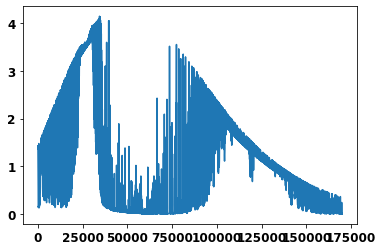

In [122]:
plt.plot(Surface_Down)

In [123]:
wl_nu = 1.e7/nu_*1.e-9
wavenum_m = nu_*1e2

In [117]:
# wavenum_m



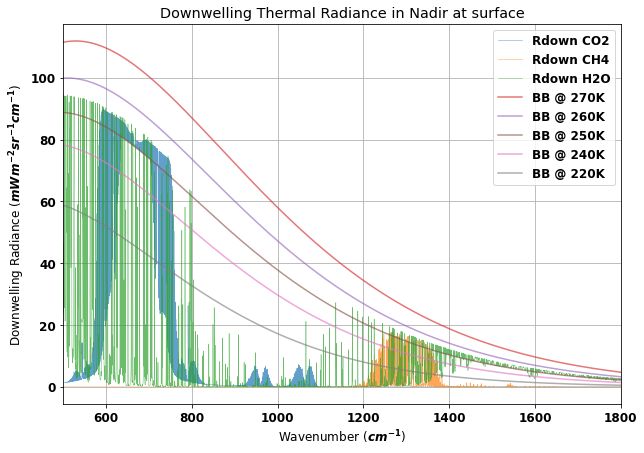

In [141]:
plt.figure(figsize = (10,7))
plt.plot(nu_, 1e3*Surface_Down_CO2,label='Rdown CO2', alpha=0.7 ,linewidth = 0.5)
plt.plot(nu_, 1e3*Surface_Down_CH4,label='Rdown CH4', alpha=0.7 ,linewidth = 0.5)
plt.plot(nu_, 1e3*Surface_Down_H2O,label='Rdown H2O', alpha=0.7 ,linewidth = 0.5)

# plt.plot(wl_nu*1e6,Surface_Down_dH2O,label='downwelling radiance at surface (double H$_2$O', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)

plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,270),label='BB @ 270K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,260),label='BB @ 260K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,250),label='BB @ 250K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,240),label='BB @ 240K',alpha=0.63)
plt.plot(nu_, W_m_mW_cm*planck_wavenumber(wavenum_m,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)

# plt.xlim((491,1799))
plt.xlim((500, 1800))
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel(r'Downwelling Radiance ($mW m^{-2} sr^{-1} cm^{-1}$)')
# plt.xlim((4,30))
plt.title('Downwelling Thermal Radiance in Nadir at surface')
plt.grid()
# plt.savefig('figs/christian_update_9_14/Rdown_gas_components_zoom.png', dpi = 300)

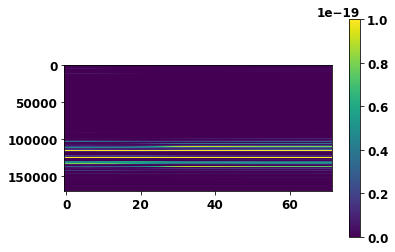

In [77]:
plt.imshow(cs_matrix_h2o, vmax = 1e-19)
plt.gca().set_aspect(0.0002)
plt.colorbar()